##Final Project - Analyzing WineEnthusiast wine reviews
Griffin Khosla

##Data Load and Formatting

In [ ]:
# basic imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
import sklearn.model_selection as mod_sel
from sklearn.metrics import accuracy_score
# Text normalizaiton/vectorization
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# MLP
import tensorflow as tf
from tensorflow import keras
from keras.backend import clear_session
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB, ComplementNB
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# unsupervised learning
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# mounting Drive (if necessary)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Data Stuff/winemag_data.csv'
wine = pd.read_csv(file_path)
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
wine = wine.drop(['id', 'region_1', 'region_2', 'taster_twitter_handle', 'title'], axis=1)
len(wine)

129971

In [ ]:
wine.isna().any()

country         True
description    False
designation     True
points         False
price           True
province        True
taster_name     True
variety         True
winery         False
dtype: bool

For supervised learning, the features will come from 'description' and the target variable is 'score'. Since both of those columns have no null values, we can proceed with the first task of normalizing the text data.

In [ ]:
reviews = wine['description']
# convert to lower case
reviews = reviews.str.lower()
# remove punctuation
reviews.replace('[^\w\s]', '', regex=True, inplace=True)
# remove numbers (vintage year info may be lost with this, but not removing numbers leaves lots of random number strings as features)
reviews.replace('\d+', '', regex=True, inplace=True)
# remove stop words
stop = stopwords.words('english')
reviews = reviews.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# view some resulting strings
wine['description_clean'] = reviews
list(reviews[:5])

['aromas include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity',
 'ripe fruity wine smooth still structured firm tannins filled juicy red berry fruits freshened acidity already drinkable although certainly better',
 'tart snappy flavors lime flesh rind dominate green pineapple pokes crisp acidity underscoring flavors wine stainlesssteel fermented',
 'pineapple rind lemon pith orange blossom start aromas palate bit opulent notes honeydrizzled guava mango giving way slightly astringent semidry finish',
 'much like regular bottling comes across rather rough tannic rustic earthy herbal characteristics nonetheless think pleasantly unfussy country wine good companion hearty winter stew']

In [ ]:
wine.head()

,country,description,designation,points,price,province,taster_name,variety,winery,description_clean
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Kerin O’Keefe,White Blend,Nicosia,aromas include tropical fruit broom brimstone ...
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Roger Voss,Portuguese Red,Quinta dos Avidagos,ripe fruity wine smooth still structured firm ...
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Paul Gregutt,Pinot Gris,Rainstorm,tart snappy flavors lime flesh rind dominate g...
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Alexander Peartree,Riesling,St. Julian,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Paul Gregutt,Pinot Noir,Sweet Cheeks,much like regular bottling comes across rather...


In [ ]:
print(wine['description_clean'][0])

aromas include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity


##Supervised Learning - Text Mining
Using review content to predict categorized review score. This be set up using a neural network architecture where the features are individual words or n-grams from the review description (multiple methods for grouping words will be tested). The first step is formatting the data (keeping only necessary columns, converting 'points' to categorical target, and splitting data into train, validation, and test sets)

###Cleaning up the data

In [ ]:
wine_sl = wine[['description_clean', 'points']]
wine_sl.head()

,description_clean,points
0,aromas include tropical fruit broom brimstone ...,87
1,ripe fruity wine smooth still structured firm ...,87
2,tart snappy flavors lime flesh rind dominate g...,87
3,pineapple rind lemon pith orange blossom start...,87
4,much like regular bottling comes across rather...,87


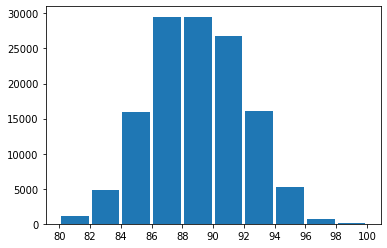

In [ ]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(wine_sl['points'], bins=10, rwidth=0.9)
ax.set_xticks(bins)
plt.show()

Points will be converted to 4 categories: 80-84, 85-89, 90-94, and 95-100

In [ ]:
bins = [79, 84, 89, 94, 100]
cats = [0, 1, 2, 3]
pd.options.mode.chained_assignment = None
wine_sl['category'] = pd.cut(wine_sl['points'], bins, labels=cats)

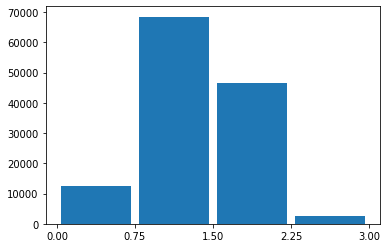

In [ ]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(wine_sl['category'], bins=4, rwidth=0.9)
ax.set_xticks(bins)
plt.show()

In [ ]:
wine_sl = wine_sl.drop(['points'], axis=1)
wine_sl.head()

,description_clean,category
0,aromas include tropical fruit broom brimstone ...,1
1,ripe fruity wine smooth still structured firm ...,1
2,tart snappy flavors lime flesh rind dominate g...,1
3,pineapple rind lemon pith orange blossom start...,1
4,much like regular bottling comes across rather...,1


###Split into train and test (stratified by category)

In [ ]:
x_train, x_test, y_train, y_test = tts(wine_sl['description_clean'], wine_sl['category'],
                                       stratify=wine_sl['category'], test_size=0.2,
                                       random_state=123)

###Naive Bayes

In [ ]:
def MNB(n_grams_min, n_grams_max, type='MNB'):
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  np.random.seed(1)
  nb = MultinomialNB()
  if type=='CNB':
    nb = ComplementNB()
  nb.fit(x_train_vec, y_train)
  print(nb.score(x_test_vec, y_test))

In [ ]:
MNB(1, 1)

0.7076360838622812


In [ ]:
MNB(1, 2)

0.7251009809578766


In [ ]:
MNB(1, 3)

0.723600692440854


In [ ]:
MNB(1, 1, type='CNB')

0.6940565493364108


In [ ]:
MNB(1, 2, type='CNB')

0.7340257741873437


In [ ]:
MNB(1, 3, type='CNB')

0.7343719946143489


###MLP

Formatting the train and test sets specifically for MLP processing

In [ ]:
def mlp_grams(n_grams_min, n_grams_max):
  # MLP 1: 2 dense layers (100 nodes each)
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  # transform categories for MLP
  y_train_mlp = keras.utils.to_categorical(y_train, 4)
  y_test_mlp = keras.utils.to_categorical(y_test, 4)
  # get number of features
  input_dim = x_train_vec.shape[1]
  # build model framework
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(100, input_dim=input_dim, activation='relu'))
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  # fit model
  np.random.seed(1)
  history = model.fit(x_train_vec, y_train_mlp, epochs=20, validation_data=(x_test_vec, y_test_mlp))
  # return plot of loss/accuracy
  return pd.DataFrame(history.history)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.8084 - accuracy: 0.6597 - val_loss: 0.6693 - val_accuracy: 0.7254
Epoch 2/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.6250 - accuracy: 0.7368 - val_loss: 0.6037 - val_accuracy: 0.7445
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5765 - accuracy: 0.7537 - val_loss: 0.5806 - val_accuracy: 0.7549
Epoch 4/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5505 - accuracy: 0.7646 - val_loss: 0.5685 - val_accuracy: 0.7584
Epoch 5/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5319 - accuracy: 0.7728 - val_loss: 0.5658 - val_accuracy: 0.7600
Epoch 6/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5159 - accuracy: 0.7802 - val_loss: 0.5565 - val_accuracy: 0.7623
Epoch 7/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5016 - accuracy: 0.7875 - val_loss: 0.5599 - val_accuracy: 0.7

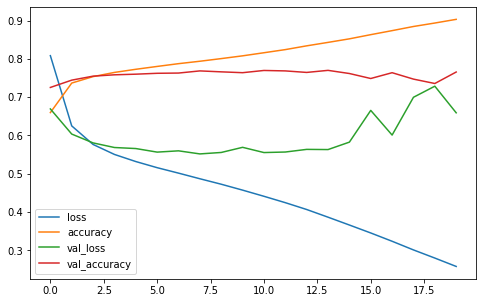

In [ ]:
mlp1_1gram = mlp_grams(1,1)
mlp1_1gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.7953 - accuracy: 0.6700 - val_loss: 0.6532 - val_accuracy: 0.7283
Epoch 2/20
3250/3250 [==============================] - 28s 8ms/step - loss: 0.5869 - accuracy: 0.7572 - val_loss: 0.5788 - val_accuracy: 0.7594
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.4941 - accuracy: 0.7983 - val_loss: 0.5573 - val_accuracy: 0.7673
Epoch 4/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.4089 - accuracy: 0.8380 - val_loss: 0.5531 - val_accuracy: 0.7736
Epoch 5/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.3193 - accuracy: 0.8811 - val_loss: 0.5812 - val_accuracy: 0.7676
Epoch 6/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.2313 - accuracy: 0.9205 - val_loss: 0.6282 - val_accuracy: 0.7658
Epoch 7/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.1565 - accuracy: 0.9516 - val_loss: 0.6678 - val_accuracy: 0.7

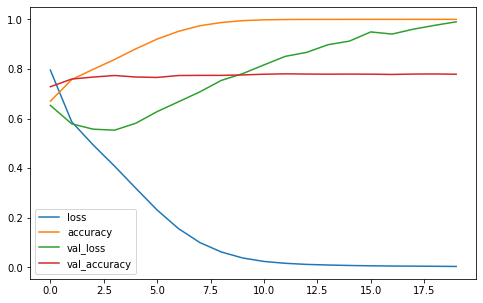

In [ ]:
mlp1_2gram = mlp_grams(1,2)
mlp1_2gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.8050 - accuracy: 0.6613 - val_loss: 0.6522 - val_accuracy: 0.7291
Epoch 2/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5638 - accuracy: 0.7683 - val_loss: 0.5716 - val_accuracy: 0.7619
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.4177 - accuracy: 0.8382 - val_loss: 0.5451 - val_accuracy: 0.7764
Epoch 4/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.2561 - accuracy: 0.9149 - val_loss: 0.6154 - val_accuracy: 0.7668
Epoch 5/20
3250/3250 [==============================] - 31s 9ms/step - loss: 0.1262 - accuracy: 0.9678 - val_loss: 0.5950 - val_accuracy: 0.7810
Epoch 6/20
3250/3250 [==============================] - 31s 9ms/step - loss: 0.0595 - accuracy: 0.9894 - val_loss: 0.6313 - val_accuracy: 0.7877
Epoch 7/20
3250/3250 [==============================] - 32s 10ms/step - loss: 0.0300 - accuracy: 0.9969 - val_loss: 0.6630 - val_accuracy: 0.

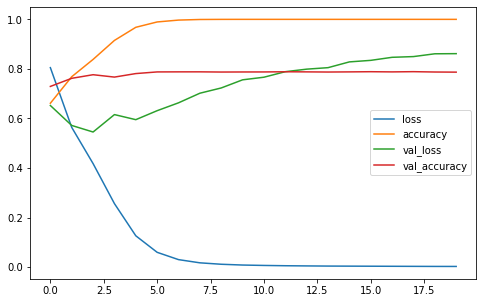

In [ ]:
mlp1_3gram = mlp_grams(1,3)
mlp1_3gram.plot(figsize=(8, 5))
clear_session()

In [ ]:
def mlp_grams2(n_grams_min, n_grams_max):
  # MLP 2 - 2dense layers (100 nodes, 0.25 dropout rate each)
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  # transform categories for MLP
  y_train_mlp = keras.utils.to_categorical(y_train, 4)
  y_test_mlp = keras.utils.to_categorical(y_test, 4)
  # get number of features
  input_dim = x_train_vec.shape[1]
  # build model framework
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(100, input_dim=input_dim, activation='relu'))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  # fit model
  np.random.seed(1)
  history = model.fit(x_train_vec, y_train_mlp, epochs=20, validation_data=(x_test_vec, y_test_mlp))
  # return plot of loss/accuracy
  return pd.DataFrame(history.history)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.8497 - accuracy: 0.6384 - val_loss: 0.6893 - val_accuracy: 0.7028
Epoch 2/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.6719 - accuracy: 0.7152 - val_loss: 0.6186 - val_accuracy: 0.7411
Epoch 3/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.6194 - accuracy: 0.7379 - val_loss: 0.5907 - val_accuracy: 0.7508
Epoch 4/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.5891 - accuracy: 0.7499 - val_loss: 0.5749 - val_accuracy: 0.7586
Epoch 5/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.5660 - accuracy: 0.7595 - val_loss: 0.5636 - val_accuracy: 0.7611
Epoch 6/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5475 - accuracy: 0.7684 - val_loss: 0.5567 - val_accuracy: 0.7645
Epoch 7/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5273 - accuracy: 0.7769 - val_loss: 0.5515 - val_accuracy: 0.7

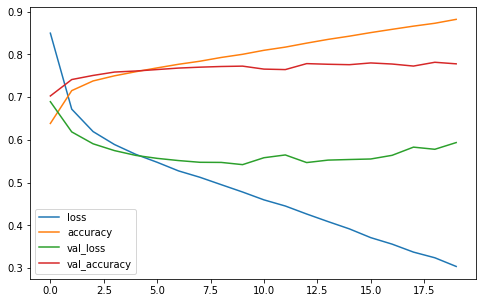

In [ ]:
mlp2_1gram = mlp_grams2(1,1)
mlp2_1gram.plot(figsize=(8, 5))
clear_session()

In [ ]:
mlp2_2gram = mlp_grams2(1,2)
mlp2_2gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 28s 8ms/step - loss: 0.8321 - accuracy: 0.6491 - val_loss: 0.6700 - val_accuracy: 0.7125
Epoch 2/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.6150 - accuracy: 0.7474 - val_loss: 0.5882 - val_accuracy: 0.7581
Epoch 3/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.4849 - accuracy: 0.8109 - val_loss: 0.5641 - val_accuracy: 0.7679
Epoch 4/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.3458 - accuracy: 0.8743 - val_loss: 0.5627 - val_accuracy: 0.7806
Epoch 5/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.2101 - accuracy: 0.9319 - val_loss: 0.6214 - val_accuracy: 0.7668
Epoch 6/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.1176 - accuracy: 0.9671 - val_loss: 0.6577 - val_accuracy: 0.7795
Epoch 7/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.0661 - accuracy: 0.9853 - val_loss: 0.6977 - val_accuracy: 0.7

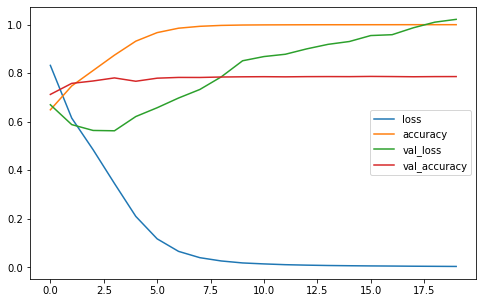

In [ ]:
mlp2_3gram = mlp_grams2(1,3)
mlp2_3gram.plot(figsize=(8, 5))
clear_session()

In [ ]:
def mlp_grams3(n_grams_min, n_grams_max):
  # MLP 3 - 2 dense layers (100 nodes, 0.4 dropout rate each)
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  # transform categories for MLP
  y_train_mlp = keras.utils.to_categorical(y_train, 4)
  y_test_mlp = keras.utils.to_categorical(y_test, 4)
  # get number of features
  input_dim = x_train_vec.shape[1]
  # build model framework
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(100, input_dim=input_dim, activation='relu'))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(100, activation='relu'))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  # fit model
  np.random.seed(1)
  history = model.fit(x_train_vec, y_train_mlp, epochs=20, validation_data=(x_test_vec, y_test_mlp))
  # return plot of loss/accuracy
  return pd.DataFrame(history.history)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.8840 - accuracy: 0.6258 - val_loss: 0.7087 - val_accuracy: 0.6986
Epoch 2/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.7000 - accuracy: 0.7042 - val_loss: 0.6314 - val_accuracy: 0.7377
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.6418 - accuracy: 0.7291 - val_loss: 0.6002 - val_accuracy: 0.7490
Epoch 4/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.6087 - accuracy: 0.7419 - val_loss: 0.5792 - val_accuracy: 0.7571
Epoch 5/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5842 - accuracy: 0.7520 - val_loss: 0.5715 - val_accuracy: 0.7573
Epoch 6/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.5659 - accuracy: 0.7614 - val_loss: 0.5612 - val_accuracy: 0.7629
Epoch 7/20
3250/3250 [==============================] - 25s 8ms/step - loss: 0.5490 - accuracy: 0.7682 - val_loss: 0.5530 - val_accuracy: 0.7

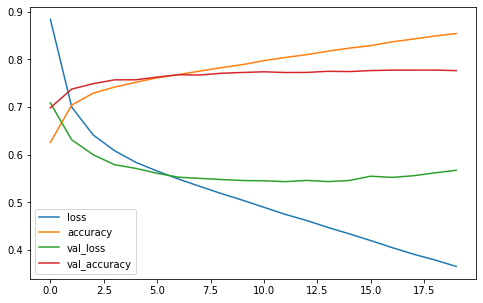

In [ ]:
mlp3_1gram = mlp_grams3(1,1)
mlp3_1gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 27s 8ms/step - loss: 0.8528 - accuracy: 0.6420 - val_loss: 0.6879 - val_accuracy: 0.7057
Epoch 2/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.6592 - accuracy: 0.7260 - val_loss: 0.6037 - val_accuracy: 0.7498
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5754 - accuracy: 0.7662 - val_loss: 0.5706 - val_accuracy: 0.7643
Epoch 4/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5065 - accuracy: 0.7961 - val_loss: 0.5543 - val_accuracy: 0.7685
Epoch 5/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.4417 - accuracy: 0.8266 - val_loss: 0.5541 - val_accuracy: 0.7756
Epoch 6/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.3731 - accuracy: 0.8574 - val_loss: 0.5601 - val_accuracy: 0.7726
Epoch 7/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.3086 - accuracy: 0.8852 - val_loss: 0.5781 - val_accuracy: 0.7

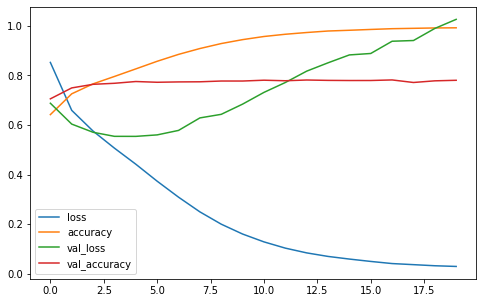

In [ ]:
mlp3_2gram = mlp_grams3(1,2)
mlp3_2gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 28s 8ms/step - loss: 0.8475 - accuracy: 0.6429 - val_loss: 0.6732 - val_accuracy: 0.7124
Epoch 2/20
3250/3250 [==============================] - 27s 8ms/step - loss: 0.6330 - accuracy: 0.7420 - val_loss: 0.5930 - val_accuracy: 0.7578
Epoch 3/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.5104 - accuracy: 0.8015 - val_loss: 0.5709 - val_accuracy: 0.7645
Epoch 4/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.3811 - accuracy: 0.8593 - val_loss: 0.5608 - val_accuracy: 0.7760
Epoch 5/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.2579 - accuracy: 0.9111 - val_loss: 0.5904 - val_accuracy: 0.7763
Epoch 6/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.1638 - accuracy: 0.9476 - val_loss: 0.6421 - val_accuracy: 0.7816
Epoch 7/20
3250/3250 [==============================] - 26s 8ms/step - loss: 0.1046 - accuracy: 0.9685 - val_loss: 0.7044 - val_accuracy: 0.7

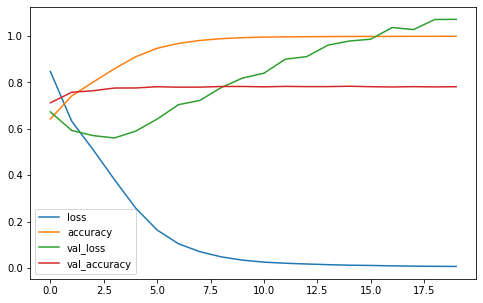

In [ ]:
mlp3_3gram = mlp_grams3(1,3)
mlp3_3gram.plot(figsize=(8, 5))
clear_session()

In [ ]:
def mlp_grams4(n_grams_min, n_grams_max):
  # MLP 4 - 2 dense layers (100 nodes, 0.001 l1 & l2 weight regularization applied to each)
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  # transform categories for MLP
  y_train_mlp = keras.utils.to_categorical(y_train, 4)
  y_test_mlp = keras.utils.to_categorical(y_test, 4)
  # get number of features
  input_dim = x_train_vec.shape[1]
  # build model framework
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(100, input_dim=input_dim, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)))
  model.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.001)))
  model.add(keras.layers.Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  # fit model
  np.random.seed(1)
  history = model.fit(x_train_vec, y_train_mlp, epochs=20, validation_data=(x_test_vec, y_test_mlp))
  # return plot of loss/accuracy
  return pd.DataFrame(history.history)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 36s 11ms/step - loss: 4.7879 - accuracy: 0.6185 - val_loss: 1.4872 - val_accuracy: 0.6673
Epoch 2/20
3250/3250 [==============================] - 35s 11ms/step - loss: 1.3064 - accuracy: 0.6765 - val_loss: 1.1482 - val_accuracy: 0.6860
Epoch 3/20
3250/3250 [==============================] - 35s 11ms/step - loss: 1.0279 - accuracy: 0.6981 - val_loss: 0.9274 - val_accuracy: 0.7138
Epoch 4/20
3250/3250 [==============================] - 34s 10ms/step - loss: 0.8550 - accuracy: 0.7133 - val_loss: 0.8070 - val_accuracy: 0.7219
Epoch 5/20
3250/3250 [==============================] - 34s 10ms/step - loss: 0.7773 - accuracy: 0.7229 - val_loss: 0.7627 - val_accuracy: 0.7280
Epoch 6/20
3250/3250 [==============================] - 34s 10ms/step - loss: 0.7557 - accuracy: 0.7285 - val_loss: 0.7674 - val_accuracy: 0.7219
Epoch 7/20
3250/3250 [==============================] - 34s 10ms/step - loss: 0.7455 - accuracy: 0.7311 - val_loss: 0.7422 - val_accura

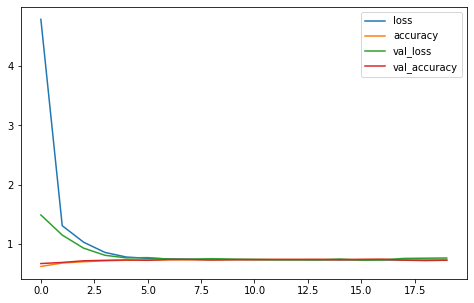

In [ ]:
mlp4_1gram = mlp_grams4(1,1)
mlp4_1gram.plot(figsize=(8, 5))
clear_session()

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3250/3250 [==============================] - 255s 78ms/step - loss: 5.1782 - accuracy: 0.6083 - val_loss: 1.8466 - val_accuracy: 0.6626
Epoch 2/20
3250/3250 [==============================] - 253s 78ms/step - loss: 1.6603 - accuracy: 0.6787 - val_loss: 1.5008 - val_accuracy: 0.6893
Epoch 3/20
3250/3250 [==============================] - 251s 77ms/step - loss: 1.3831 - accuracy: 0.7006 - val_loss: 1.2941 - val_accuracy: 0.7060
Epoch 4/20
3250/3250 [==============================] - 251s 77ms/step - loss: 1.2243 - accuracy: 0.7165 - val_loss: 1.1794 - val_accuracy: 0.7236
Epoch 5/20
3250/3250 [==============================] - 252s 77ms/step - loss: 1.1598 - accuracy: 0.7236 - val_loss: 1.1512 - val_accuracy: 0.7258
Epoch 6/20
3250/3250 [==============================] - 252s 77ms/step - loss: 1.1477 - accuracy: 0.7267 - val_loss: 1.1479 - val_accuracy: 0.7293
Epoch 7/20
3250/3250 [==============================] - 252s 77ms/step - loss: 1.1431 - accuracy: 0.7291 - val_loss: 1.1583 - val

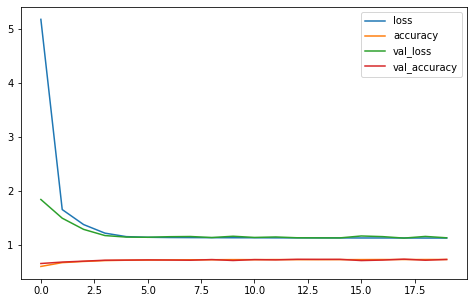

In [ ]:
mlp4_2gram = mlp_grams4(1,2)
mlp4_2gram.plot(figsize=(8, 5))
clear_session()

###Random Forest

In [ ]:
def RF_grams(n_grams_min, n_grams_max, max_depth, n_est=100):
  # instantiate vectorizer
  vec = CountVectorizer(ngram_range=(n_grams_min, n_grams_max)).fit(x_train)
  # fit training and test texts to vectorizer (vect based only on trian data)
  x_train_vec = vec.transform(x_train)
  x_test_vec = vec.transform(x_test)
  np.random.seed(1)
  rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_est)
  rf_mod = rf.fit(x_train_vec, y_train)
  y_pred_rf = rf_mod.predict(x_test_vec)
  return accuracy_score(y_test, y_pred_rf)

In [ ]:
# 1 grams with different maximum depths, 100 trees
rf_1gram_dict = {}
for depth in [10, 20, 30, 50, 75, 100]:
  rf_1gram = RF_grams(1, 1, depth)
  rf_1gram_dict[depth] = rf_1gram
print(rf_1gram_dict)

{10: 0.5299095979996153, 20: 0.572533179457588, 30: 0.618426620503943, 50: 0.6711290632814003, 75: 0.6969801884977881, 100: 0.709020965570302}


In [ ]:
# 1 grams, no max depth, 100 trees
print(RF_grams(1, 1, None))

0.7287939988459319


In [ ]:
# 1 grams, different depths, 150 trees
rf_1gram_dict = {}
for depth in [10, 20, 30, 50, 75, 100]:
  rf_1gram = RF_grams(1, 1, depth, n_est=150)
  rf_1gram_dict[depth] = rf_1gram
print(rf_1gram_dict)

{10: 0.5295633775726101, 20: 0.5703404500865551, 30: 0.6183112136949414, 50: 0.673821888824774, 75: 0.6999422965954991, 100: 0.7119830736680131}


In [ ]:
# 1 grams, no max depth, 150 trees
print(RF_grams(1, 1, None, n_est=150))

0.7336026158876707


In [ ]:
# 2 grams, different max depths, 100 trees
rf_2gram_dict = {}
for depth in [10, 20, 30, 50, 75, 100]:
  rf_2gram = RF_grams(1, 2, depth)
  rf_2gram_dict[depth] = rf_2gram
print(rf_2gram_dict)

{10: 0.527024427774572, 20: 0.5280630890555876, 30: 0.5378341988844009, 50: 0.5760723216003077, 75: 0.6239661473360262, 100: 0.6550105789574918}


In [ ]:
# 2 grams, no max depth, 100 trees
print(RF_grams(1, 2, None))

0.6922485093287171


In [ ]:
# 2 grams, different max depths, 150 trees
rf_2gram_dict = {}
for depth in [10, 20, 30, 50, 75, 100]:
  rf_2gram = RF_grams(1, 2, depth, n_est=150)
  rf_2gram_dict[depth] = rf_2gram
print(rf_2gram_dict)

{10: 0.527024427774572, 20: 0.5278322754375842, 30: 0.5369878822850548, 50: 0.5773417964993268, 75: 0.6260819388343912, 100: 0.6569340257741874}


In [ ]:
# 2 grams, no max depth, 150 trees
print(RF_grams(1, 2, None, n_est=150))

0.6948259280630891


##Unsupervised Learning - Topic Modeling with LDA

In [ ]:
wine_ul = pd.Series(wine['description_clean'])
wine_ul.head()

0    aromas include tropical fruit broom brimstone ...
1    ripe fruity wine smooth still structured firm ...
2    tart snappy flavors lime flesh rind dominate g...
3    pineapple rind lemon pith orange blossom start...
4    much like regular bottling comes across rather...
Name: description_clean, dtype: object

In [ ]:
vect_ul = CountVectorizer(max_features=10000, max_df=0.2)
x = vect_ul.fit_transform(wine_ul)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

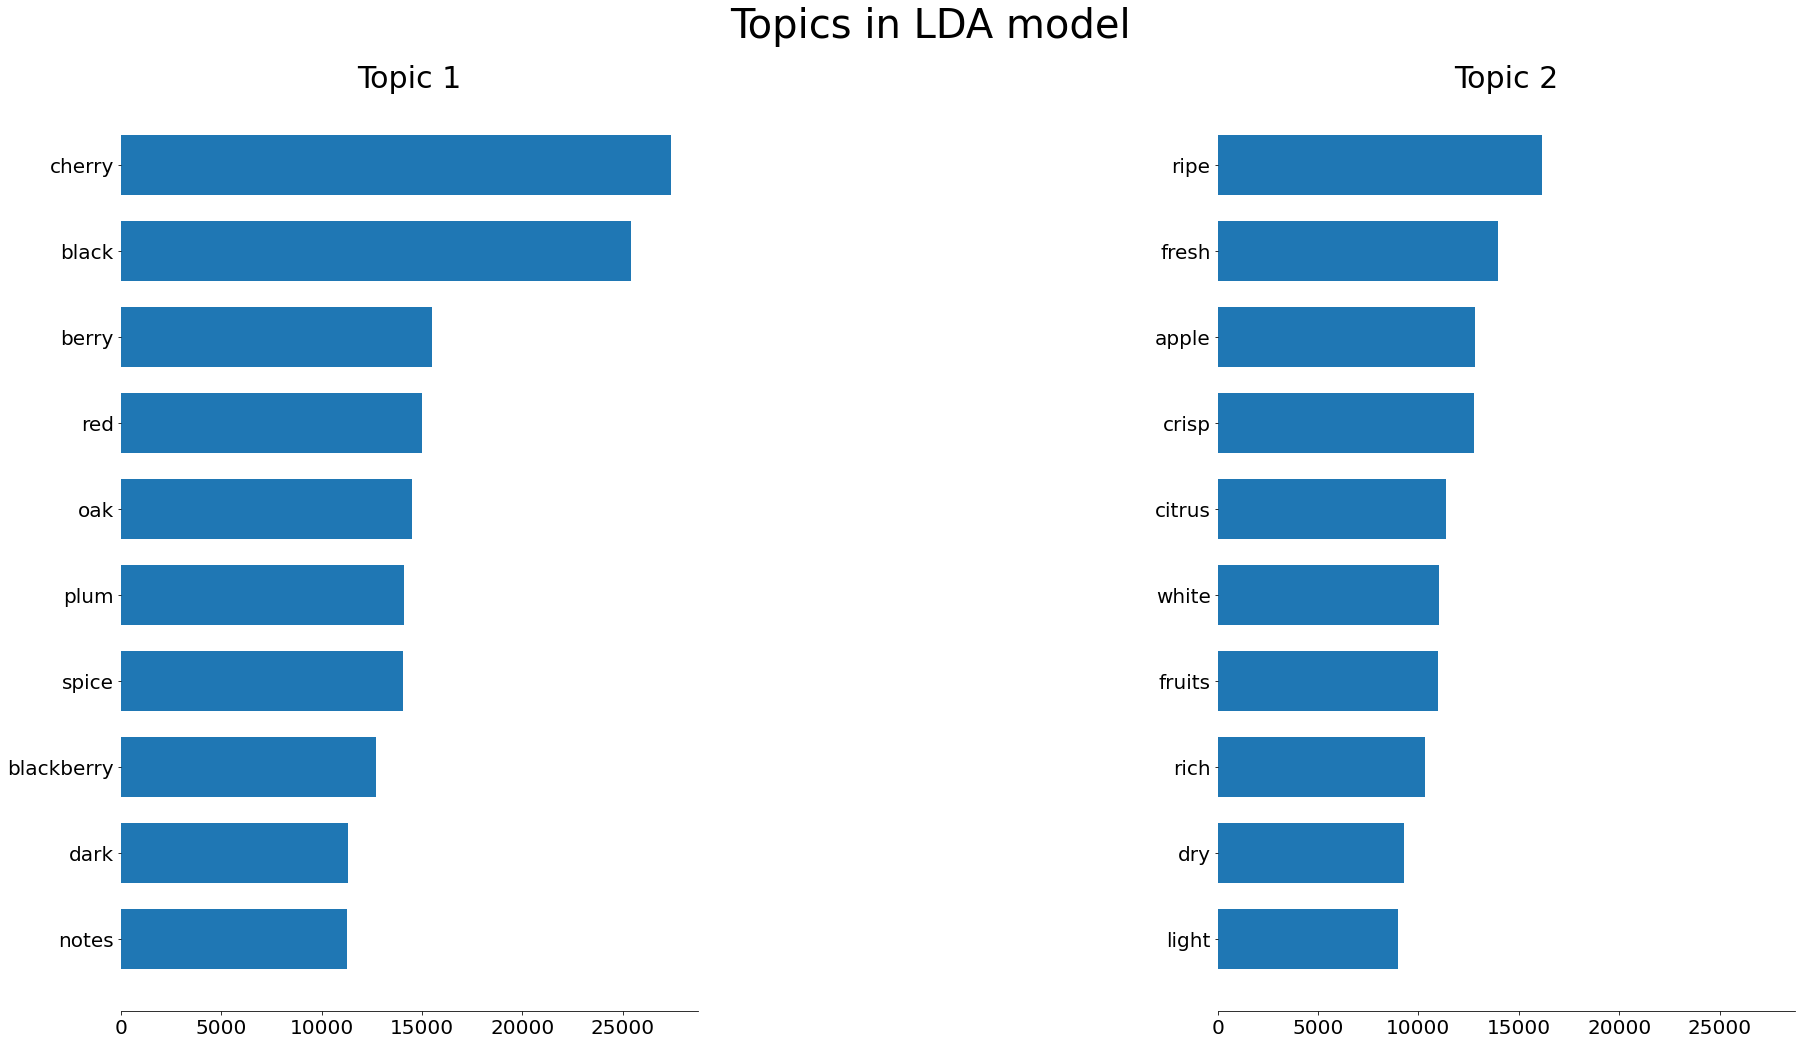

In [ ]:
# 2 topics
lda = LDA(n_components=2, learning_method='batch', max_iter=25)
doc_topics = lda.fit(x)
tf_feature_names = vect_ul.get_feature_names_out()
plot_top_words(doc_topics, tf_feature_names, 10, "Topics in LDA model")

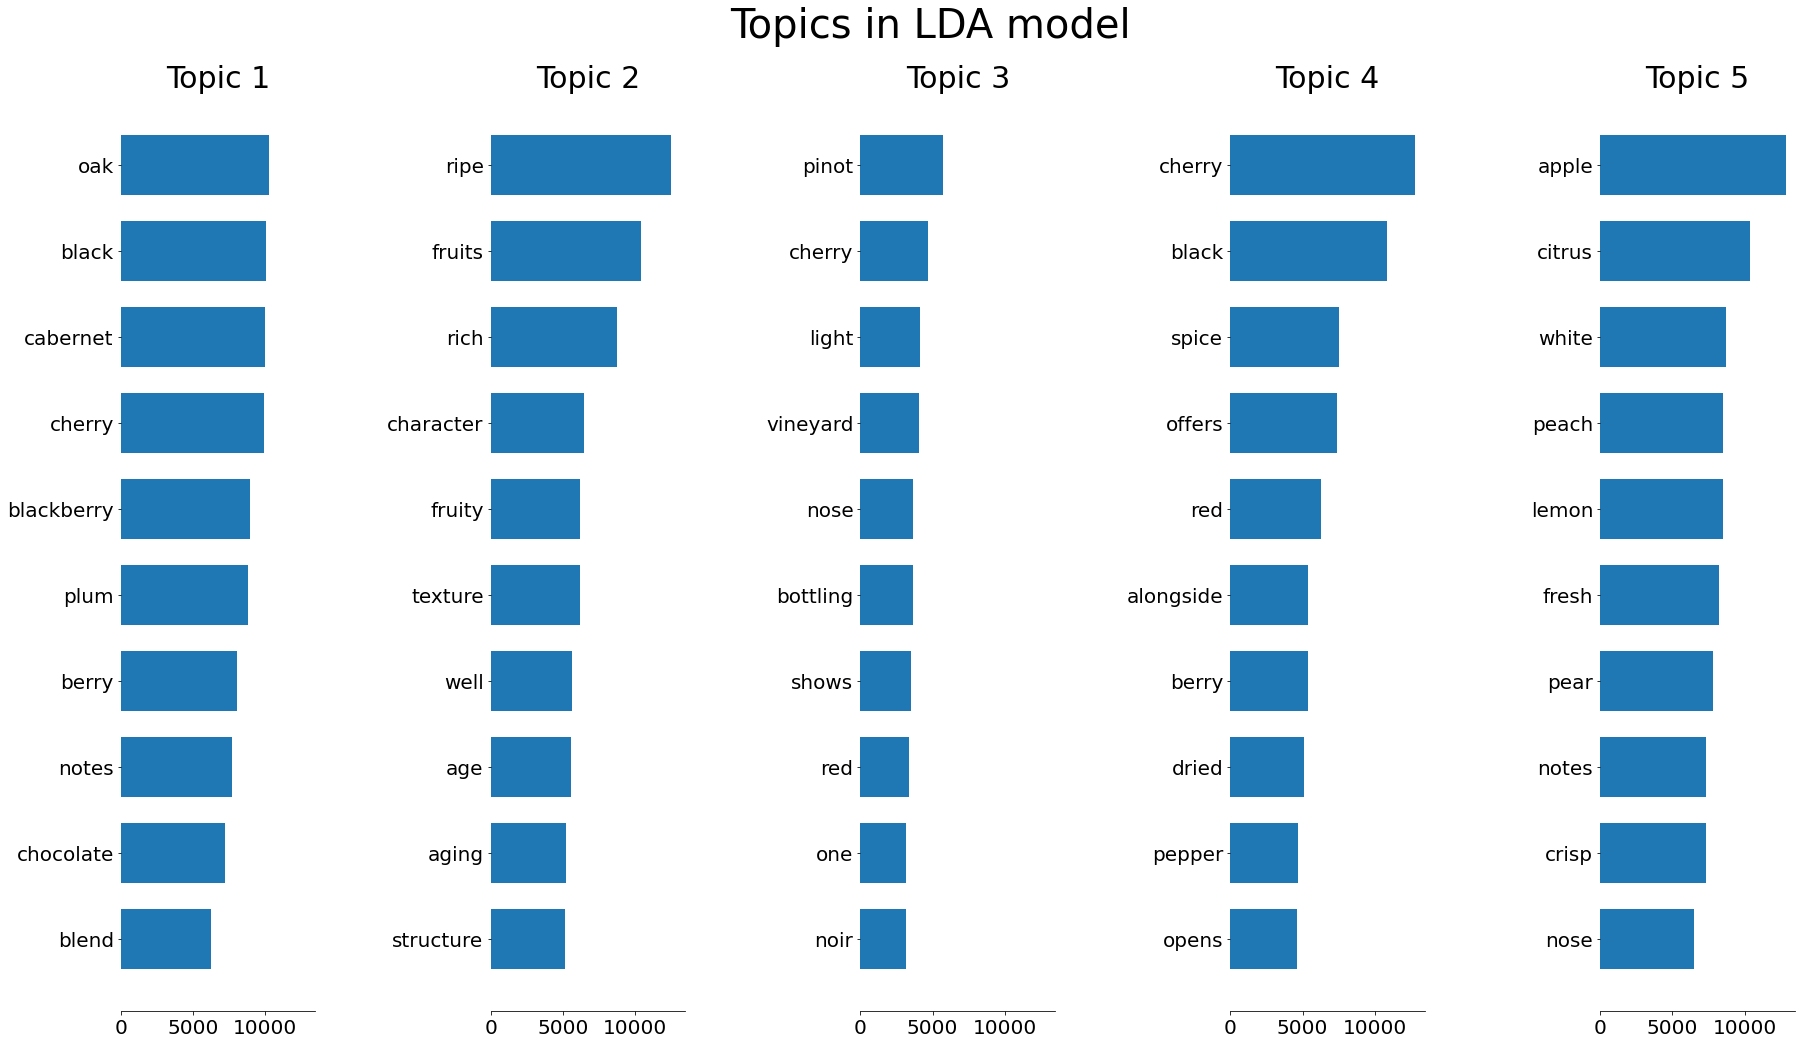

In [ ]:
# 5 topics
lda5 = LDA(n_components=5, learning_method='batch', max_iter=25)
doc_topics = lda5.fit(x)
tf_feature_names = vect_ul.get_feature_names_out()
plot_top_words(doc_topics, tf_feature_names, 10, "Topics in LDA model")

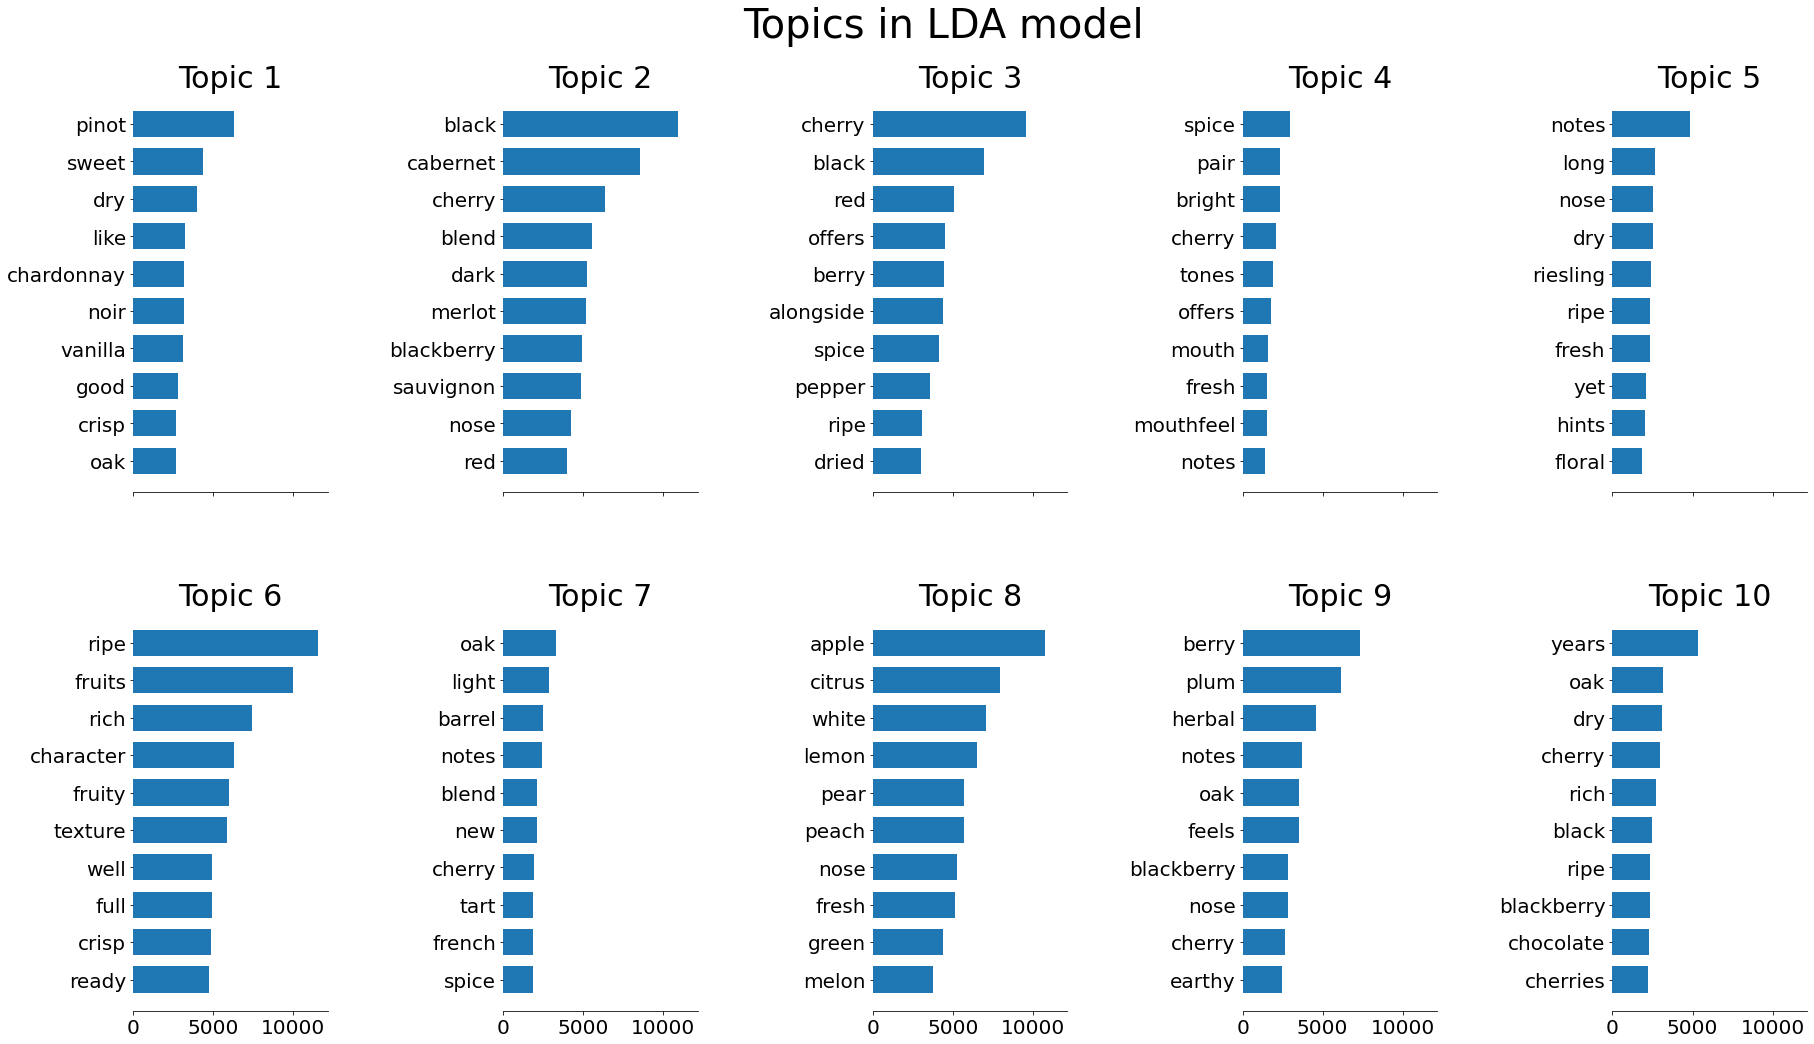

In [ ]:
# 10 topics
lda10 = LDA(n_components=10, learning_method='batch', max_iter=25)
doc_topics = lda10.fit(x)
tf_feature_names = vect_ul.get_feature_names_out()
plot_top_words(doc_topics, tf_feature_names, 10, "Topics in LDA model")